In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
batch_size = 100
img_height = 224
img_width = 224


In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            color_mode="rgb",
                                                            image_size=(img_height, img_width),
                                                            batch_size = 100)




Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2)
                                         ])


In [5]:
rescale = tf.keras.layers.Rescaling(1./255)


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(img_height, img_width, 3)),
                                data_augmentation,
                                rescale,
                                base_model,
                                tf.keras.layers.GlobalMaxPooling2D(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(1, activation="sigmoid")])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [57]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = tf.keras.layers.RandomFlip("horizontal")(inputs)
augmented = tf.keras.layers.RandomRotation(0.2)(augmented)
mobilenet = base_model(augmented)
pooling = tf.keras.layers.GlobalMaxPooling2D()(mobilenet)
dropout = tf.keras.layers.Dropout(0.2)(pooling)
outputs = tf.keras.layers.Dense(1, activation="softmax")(dropout)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                           

In [8]:
n_epochs=5
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/5
42/42 [==============================] - 137s 3s/step - loss: 1.2226 - accuracy: 0.6729 - precision: 0.7754 - recall: 0.7808 - auc: 0.6201 - val_loss: 0.3207 - val_accuracy: 0.8600 - val_precision: 0.9289 - val_recall: 0.8877 - val_auc: 0.9169
Epoch 2/5
42/42 [==============================] - 125s 3s/step - loss: 0.4975 - accuracy: 0.8133 - precision: 0.8647 - recall: 0.8842 - auc: 0.8624 - val_loss: 0.2681 - val_accuracy: 0.8936 - val_precision: 0.9679 - val_recall: 0.8926 - val_auc: 0.9550
Epoch 3/5
42/42 [==============================] - 125s 3s/step - loss: 0.4076 - accuracy: 0.8543 - precision: 0.8982 - recall: 0.9041 - auc: 0.9076 - val_loss: 0.2349 - val_accuracy: 0.9041 - val_precision: 0.9746 - val_recall: 0.9000 - val_auc: 0.9663
Epoch 4/5
42/42 [==============================] - 130s 3s/step - loss: 0.3318 - accuracy: 0.8756 - precision: 0.9093 - recall: 0.9227 - auc: 0.9339 - val_loss: 0.2038 - val_accuracy: 0.9214 - val_precision: 0.9715 - val_recall: 0.9259 - 

Text(0.5, 1.0, 'Training and validation accuracy')

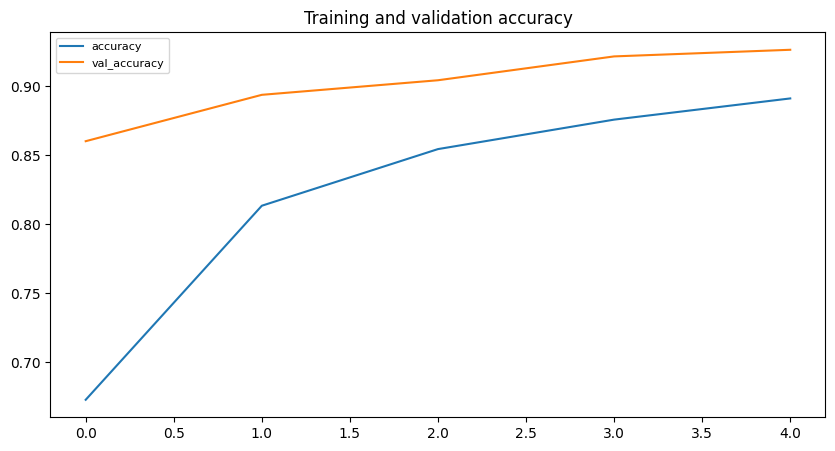

In [9]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)


Text(0.5, 1.0, 'Training and validation precision')

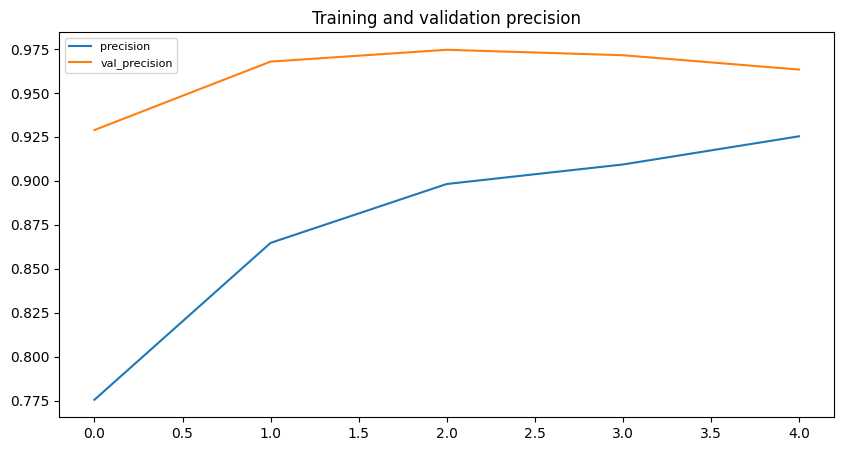

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

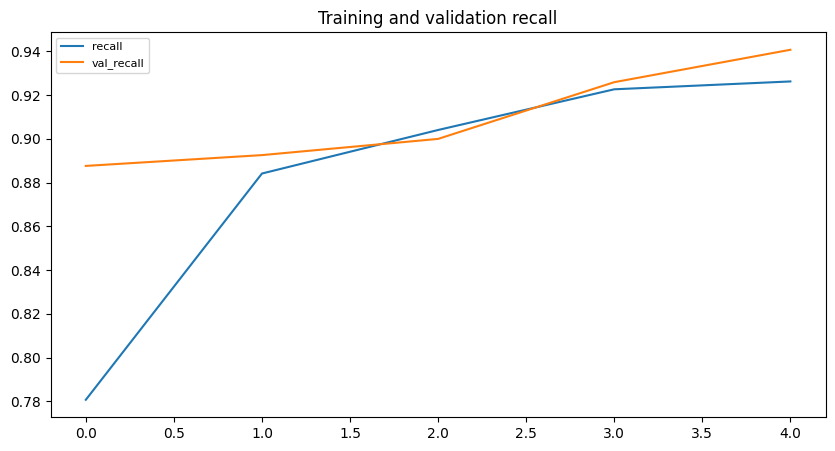

In [17]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [12]:
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,1.222634,0.672897,0.775437,0.780750,0.620104,0.320695,0.860019,0.928941,0.887654,0.916942
1,0.497454,0.813324,0.864710,0.884176,0.862371,0.268095,0.893576,0.967871,0.892593,0.955002
2,0.407625,0.854301,0.898217,0.904078,0.907630,0.234924,0.904123,0.974599,0.900000,0.966259
3,0.331820,0.875629,0.909325,0.922675,0.933921,0.203809,0.921381,0.971503,0.925926,0.971189
4,0.300303,0.890966,0.925359,0.926264,0.945556,0.177889,0.926175,0.963338,0.940741,0.974418


In [13]:
model.evaluate(test_dataset)

7/7 [==============================] - 18s 2s/step - loss: 0.5534 - accuracy: 0.8045 - precision: 0.7769 - recall: 0.9641 - auc: 0.9052


[0.5533642768859863,
 0.8044871687889099,
 0.7768595218658447,
 0.964102566242218,
 0.9051775336265564]

In [14]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  prediction_prob = model.predict(x).flatten()
  predictions = np.concatenate([predictions, tf.where(prediction_prob < 0.5, 0, 1)])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 1s 902ms/step


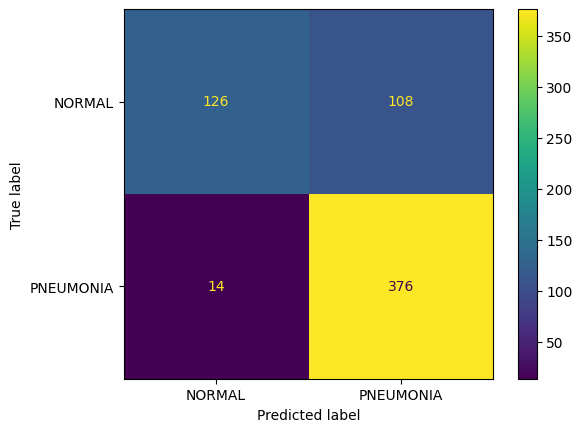

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(labels, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot()
plt.show()

In [66]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs = [model.get_layer('mobilenetv2_1.00_224').input],
        outputs = [model.get_layer('mobilenetv2_1.00_224').get_layer(last_conv_layer_name).output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [31]:
image, label = next(iter(test_dataset))
img_tensor = image[3]
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor.shape

(1, 224, 224, 3)

In [62]:
last_conv_layer_name  = "Conv1"

In [36]:
model.layers[-1].activation = None

In [37]:
preds = model.predict(img_tensor)

1/1 [==============================] - 0s 248ms/step


In [39]:
preds

array([[0.9998775]], dtype=float32)

In [54]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), base_model.layers))[-1].name
last_conv_layer_name

'Conv_1'

In [74]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [76]:
for layer in model.layers:
    print(f'{layer}: {len(layer.output_shape)}')

<keras.engine.input_layer.InputLayer object at 0x000001EE8FA2E1A0>: 1
<keras.layers.preprocessing.image_preprocessing.RandomFlip object at 0x000001EE8FA2E170>: 4
<keras.layers.preprocessing.image_preprocessing.RandomRotation object at 0x000001EE8F9A2380>: 4
<keras.engine.functional.Functional object at 0x000001EE8435FE80>: 4
<keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x000001EE92D26D70>: 2
<keras.layers.regularization.dropout.Dropout object at 0x000001EE8FC78850>: 2
<keras.layers.core.dense.Dense object at 0x000001EE8D7B1720>: 2


In [73]:
grad_model = tf.keras.models.Model(
    inputs = [model.get_layer('mobilenetv2_1.00_224').input],
    outputs = [model.get_layer('mobilenetv2_1.00_224').get_layer(last_conv_layer_name).output]
)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "random_flip_2". The following previous layers were accessed without issue: []

In [71]:
# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
grad_model(img_tensor)

<tf.Tensor: shape=(1, 112, 112, 32), dtype=float32, numpy=
array([[[[ 1.90562897e+01, -9.96810074e+01, -8.18195343e-01, ...,
           1.16503835e+00,  6.13048897e+01,  7.06992626e+00],
         [ 1.00544024e+01, -1.94507706e+00,  4.94545013e-01, ...,
           1.58058810e+00,  1.05477667e+01,  5.06174612e+00],
         [ 1.13961449e+01, -7.50719910e+01, -3.68091702e-01, ...,
           5.66028357e-01,  4.06131706e+01,  4.96393871e+00],
         ...,
         [ 7.82480907e+00, -3.32039046e+00, -1.21362712e-02, ...,
           9.29546416e-01,  1.58634501e+01,  3.97424674e+00],
         [ 6.05963802e+00, -5.73019838e+00,  2.90669352e-02, ...,
           7.03591108e-01,  1.37082882e+01,  3.33100438e+00],
         [ 6.47521019e+00,  9.27496338e+00, -9.55938995e-02, ...,
           5.42021990e-01,  1.31873207e+01,  3.30617356e+00]],

        [[ 2.21070766e+01, -1.24435568e+00,  7.26009488e-01, ...,
           1.87942874e+00,  3.99862747e+01,  5.44696856e+00],
         [ 8.10798740e+00, -6

In [67]:
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)